# 更多的测试手法
在前面的文章中，我们一起学习了Go程序测试的基础知识和基本测试手法。这主要包括了Go程序测试的基本规则和主要流程、testing.T类型和testing.B类型的常用方法、go test命令的基本使用方式、常规测试结果的解读等等。

在本篇文章，我会继续为你讲解更多更高级的测试方法。这会涉及testing包中更多的API、go test命令支持的，更多标记更加复杂的测试结果，以及测试覆盖度分析等等。

## 前导内容：-cpu的功能
续接前文。我在前面提到了go test命令的标记-cpu，它是用来设置测试执行最大P数量的列表的。

复习一下，我在讲go语句的时候说过，这里的P是processor的缩写，每个processor都是一个可以承载若干个G，且能够使这些G适时地与M进行对接并得到真正运行的中介。

正是由于P的存在，G和M才可以呈现出多对多的关系，并能够及时、灵活地进行组合和分离。

这里的G就是goroutine的缩写，可以被理解为Go语言自己实现的用户级线程。M即为machine的缩写，代表着系统级线程，或者说操作系统内核级别的线程。

Go语言并发编程模型中的P，正是goroutine的数量能够数十万计的关键所在。P的数量意味着Go程序背后的运行时系统中，会有多少个用于承载可运行的G的队列存在。

每一个队列都相当于一条流水线，它会源源不断地把可运行的G输送给空闲的M，并使这两者对接。

一旦对接完成，被对接的G就真正地运行在操作系统的内核级线程之上了。每条流水线之间虽然会有联系，但都是独立运作的。

因此，最大P数量就代表着Go语言运行时系统同时运行goroutine的能力，也可以被视为其中逻辑CPU的最大个数。而go test命令的-cpu标记正是用于设置这个最大个数的。

也许你已经知道，在默认情况下，最大P数量就等于当前计算机CPU核心的实际数量。

当然了，前者也可以大于或者小于后者，如此可以在一定程度上模拟拥有不同的CPU核心数的计算机。

所以，也可以说，使用-cpu标记可以模拟：被测程序在计算能力不同计算机中的表现。

现在，你已经知道了-cpu标记的用途及其背后的含义。那么它的具体用法，以及对go test命令的影响你是否也清楚呢？

**今天的问题是怎样设置`-cpu`标记的值，以及它会对测试流程产生什么样的影响**

**典型回答是**
标记`-cpu`的值应该是一个正整数的列表，该列表的表现形式为：以英文半角逗号分隔的多个整数字面量，比如1,2,4。

针对于此值中的每一个正整数，`go test`命令都会先设置最大P数量为该数，然后再执行测试函数。

如果测试函数有多个，那么`go test`命令会依照此方式逐个执行。

以1,2,4为例，`go test`命令会先以1,2,4为最大P数量分别去执行第一个测试函数，之后再用同样的方式执行第二个测试函数，以此类推。

## 问题解析：
实际上，不论我们是否追加了`-cpu`标记，`go test`命令执行测试函数时流程都是相同的，只不过具体执行步骤会略有不同。

`go test`命令在进行准备工作的时候会读取`-cpu`标记的值，并把它转换为一个以`int`为元素类型的切片，我们也可以称它为逻辑`CPU切片`。

如果该命令发现我们并没有追加这个标记，那么就会让逻辑CPU切片只包含一个元素值，即最大P数量的默认值，也就是当前计算机CPU核心的实际数量。

在准备执行某个测试函数的时候，无论该函数是功能测试函数，还是性能测试函数，`go test`命令都会迭代`逻辑CPU切片`，并且在每次迭代时，先依据当前的元素值设置最大P数量，然后再去执行测试函数。

注意，对于性能测试函数来说，这里可能不只执行了一次。你还记得测试函数的执行时间上限，以及那个由b.N代表的被测程序的执行次数吗？

如果你忘了，那么可以再复习一下上篇文章中的第二个扩展问题。概括来讲，`go test`命令每一次对性能测试函数的执行，都是一个探索的过程。**它会在测试函数的执行时间上限不变的前提下，尝试找到被测程序的最大执行次数。**

在这个过程中，性能测试函数可能会被执行多次。为了以后描述方便，我们把这样一个探索的过程称为：对性能测试函数的一次探索式执行，这其中包含了对该函数的若干次执行，当然，肯定也包括了对被测程序更多次的执行。

说到多次执行测试函数，我们就不得不提及另外一个标记，即-count。-count标记是专门用于重复执行测试函数的。它的值必须大于或等于0，并且默认值为1。

如果我们在运行go test命令的时候追加了-count 5，那么对于每一个测试函数，命令都会在预设的不同条件下（比如不同的最大P数量下）分别重复执行五次。

如果我们把前文所述的-cpu标记、-count标记，以及探索式执行联合起来看，就可以用一个公式来描述单个性能测试函数，在go test命令的一次运行过程中的执行次数，即：
`性能测试函数的执行次数 = -cpu标记的值中正整数的个数 x -count标记的值 x 探索式执行中测试函数的实际执行次数`

对于功能测试函数来说，这个公式会更加简单一些，即：
功能测试函数的执行次数 = `-cpu`标记的值中正整数的个数 x `-count`标记的值
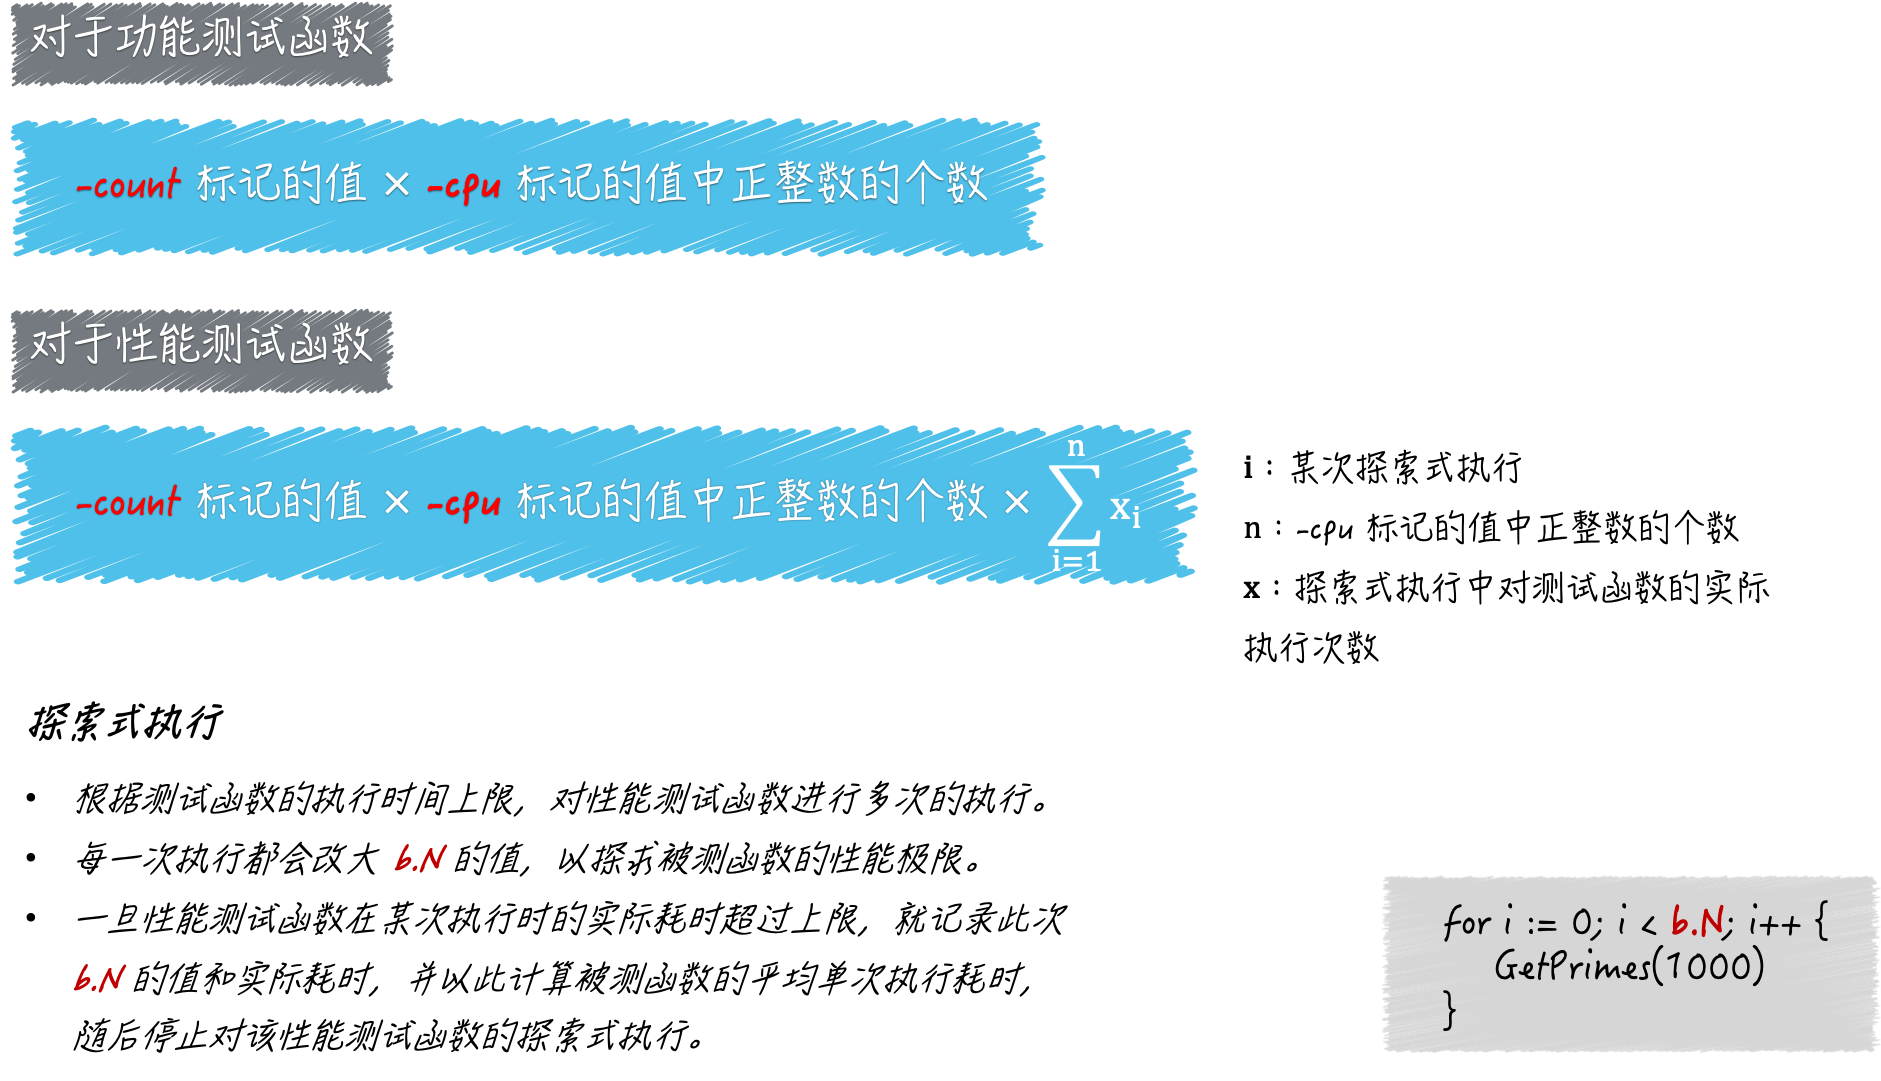

看完了这两个公式，我想，你也许遇到过这种情况，**在对Go程序执行某种自动化测试的过程中，测试日志会显得特别多，而且好多都是重复的。**

这时，我们首先就应该想到，上面这些导致测试函数多次执行的标记和流程。我们往往需要检查这些标记的使用是否合理、日志记录是否有必要等等，从而对测试日志进行精简。

比如，对于功能测试函数来说，我们通常没有必要重复执行它，即使是在不同的最大P数量下也是如此。注意，这里所说的重复执行指的是，在被测程序的输入（比如说被测函数的参数值）相同情况下的多次执行。

有些时候，在输入完全相同的情况下，被测程序会因其他外部环境的不同，而表现出不同的行为。这时我们需要考虑的往往应该是：这个程序在设计上是否合理，而不是通过重复执行测试来检测风险。

还有些时候，我们的程序会无法避免地依赖一些外部环境，比如数据库或者其他服务。这时，我们依然不应该让测试的反复执行成为检测手段，而应该在测试中通过仿造（mock）外部环境，来规避掉它们的不确定性。

其实，**单元测试的意思就是：对单一的功能模块进行边界清晰的测试，并且不掺杂任何对外部环境的检测。这也是“单元”二字要表达的主要含义。**

正好相反，对于性能测试函数来说，我们常常需要反复地执行，并以此试图抹平当时的计算资源调度的细微差别对被测程序性能的影响。通过-cpu标记，我们还能够模拟被测程序在计算能力不同计算机中的性能表现。

不过要注意，这里设置的最大P数量，最好不要超过当前计算机CPU核心的实际数量。因为一旦超出计算机实际的并行处理能力，Go程序在性能上就无法再得到显著地提升了。

这就像一个漏斗，不论我们怎样灌水，水的漏出速度总是有限的。更何况，为了管理过多的P，Go语言运行时系统还会耗费额外的计算资源。

显然，上述模拟得出的程序性能一定是不准确的。不过，这或多或少可以作为一个参考，因为，这样模拟出的性能一般都会低于程序在计算环境中的实际性能。

好了，关于-cpu标记，以及由此引出的-count标记和测试函数多次执行的问题，我们就先聊到这里。不过，为了让你再巩固一下前面的知识，我现在给出一段测试结果：
pkg: puzzlers/article21/q1
BenchmarkGetPrimesWith100-2        10000000        218 ns/op
BenchmarkGetPrimesWith100-2        10000000        215 ns/op
BenchmarkGetPrimesWith100-4        10000000        215 ns/op
BenchmarkGetPrimesWith100-4        10000000        216 ns/op
BenchmarkGetPrimesWith10000-2         50000      31523 ns/op
BenchmarkGetPrimesWith10000-2         50000      32372 ns/op
BenchmarkGetPrimesWith10000-4         50000      32065 ns/op
BenchmarkGetPrimesWith10000-4         50000      31936 ns/op
BenchmarkGetPrimesWith1000000-2         300    4085799 ns/op
BenchmarkGetPrimesWith1000000-2         300    4121975 ns/op
BenchmarkGetPrimesWith1000000-4         300    4112283 ns/op
BenchmarkGetPrimesWith1000000-4         300    4086174 ns/op

这里应该是-cpu 2,4 -mount 2

## 知识扩展
### 问题一：-parallel标记的作用是什么？
我们在运行`go test`命令的时候，可以追加标记`-parallel`，该标记的作用是：设置同一个被测代码包中的功能测试函数的最大并发执行数。该标记的默认值是测试运行时的最大P数量（这可以通过调用表达式`runtime.GOMAXPROCS(0)`获得）。

我在上篇文章中已经说过，对于功能测试，为了加快测试速度，命令通常会并发地测试多个被测代码包。

但是，在默认情况下，对于同一个被测代码包中的多个功能测试函数，命令会串行地执行它们。除非我们在一些功能测试函数中显式地调用`t.Parallel`方法。

这个时候，这些包含了`t.Parallel`方法调用的功能测试函数就会被`go test`命令并发地执行，而并发执行的最大数量正是由`-parallel`标记值决定的。不过要注意，同一个功能测试函数的多次执行之间一定是串行的。

你可以运行命令`go test -v puzzlers/article21/q2`或者`go test -count=2 -v puzzlers/article21/q2`，查看测试结果，然后仔细地体会一下。

最后，强调一下，`-parallel`标记对性能测试是无效的。当然了，对于性能测试来说，也是可以并发进行的，不过机制上会有所不同。

概括地讲，这涉及了b.RunParallel方法、b.SetParallelism方法和-cpu标记的联合运用。如果想进一步了解，你可以查看testing代码包的文档。

### 问题2：性能测试函数中的计时器是做什么用的？
如果你看过`testing`包的文档，那么很可能会发现其中的`testing.B`类型有这么几个指针方法：`StartTimer`、`StopTimer`和`ResetTimer`。这些方法都是用于操作当前的性能测试函数专属的计时器的。

所谓的计时器，是一个逻辑上的概念，它其实是`testing.B`类型中一些字段的统称。这些字段用于记录：当前测试函数在当次执行过程中耗费的时间、分配的堆内存的字节数以及分配次数。

我在下面会以测试函数的执行时间为例，来说明此计时器的用法。不过，你需要知道的是，这三个方法在开始记录、停止记录或重新记录执行时间的同时，也会对堆内存分配字节数和分配次数的记录起到相同的作用。

实际上，`go test`命令本身就会用到这样的计时器。当准备执行某个性能测试函数的时候，命令会重置并启动该函数专属的计时器。一旦这个函数执行完毕，命令又会立即停止这个计时器。

如此一来，命令就能够准确地记录下（我们在前面多次提到的）测试函数执行时间了。然后，命令就会将这个时间与执行时间上限进行比较，并决定是否在改大b.N的值之后，再次执行测试函数。

还记得吗？这就是我在前面讲过的，对性能测试函数的探索式执行。显然，如果我们在测试函数中自行操作这个计时器，就一定会影响到这个探索式执行的结果。也就是说，这会让命令找到被测程序的最大执行次数有所不同。

请看在demo57_test.go文件中的那个性能测试函数，如下所示：

In [1]:
func BenchmarkGetPrimes(b *testing.B) {
 b.StopTimer()
 time.Sleep(time.Millisecond * 500) // 模拟某个耗时但与被测程序关系不大的操作。
 max := 10000
 b.StartTimer()

 for i := 0; i < b.N; i++ {
  GetPrimes(max)
 }
}

# gonb_094113d4 

 

 ./main.go:16:3: undefined: GetPrimes
 
 b.StartTimer()

 for i := 0; i < b.N; i++ {
 GetPrimes(max)
 }
}

ERROR: failed to run "/usr/bin/go build -o /tmp/gonb_094113d4/gonb_094113d4": exit status 1

需要注意的是该函数体中的前四行代码。我先停止了当前测试函数的计时器，然后通过调用time.Sleep函数，模拟了一个比较耗时的额外操作，并且在给变量max赋值之后又启动了该计时器。

你可以想象一下，我们需要耗费额外的时间去确定max变量的值，虽然在后面它会被传入GetPrimes函数，但是，**针对GetPrimes函数本身的性能测试并不应该包含确定参数值的过程。**

因此，我们需要把这个过程所耗费的时间，从当前测试函数的执行时间中去除掉。这样就能够避免这一过程对测试结果的不良影响了。

每当这个测试函数执行完毕后，`go test`命令拿到的执行时间都只应该包含调用`GetPrimes函数`所耗费的那些时间。只有依据这个时间做出的后续判断，以及找到被测程序的最大执行次数才是准确的。

在性能测试函数中，我们可以通过对`b.StartTimer`和`b.StopTimer`方法的联合运用，再去除掉任何一段代码的执行时间。

相比之下，`b.ResetTimer`方法的灵活性就要差一些了，它只能用于：去除在调用它之前那些代码的执行时间。不过，无论在调用它的时候，计时器是不是正在运行，它都可以起作用。

## 总结
在本篇文章中，我假设你已经理解了上一篇文章涉及的内容。因此，我在这里围绕着几个可以被`go test`命令接受的重要标记，进一步地阐释了功能测试和性能测试在不同条件下的测试流程。

其中，比较重要的有最大P数量的含义，`-cpu`标记的作用及其对测试流程的影响，针对性能测试函数的探索式执行的意义，测试函数执行时间的计算方法，以及`-count`标记的用途和适用场景。

当然了，学会怎样并发地执行多个功能测试函数也是很有必要的。这需要联合运用`-parallel标记`和功能测试函数中的`t.Parallel方法`。

另外，你还需要知道`性能测试函数专属计时器`的内涵，以及那三个方法对计时器起到的作用。通过对计时器的操作，我们可以达到精确化性能测试函数的执行时间的目的，从而帮助go test命令找到被测程序真实的最大执行次数。

到这里，我们对Go程序测试的讨论就要告一段落了。我们需要搞清楚的是，`go test`命令所执行的基本测试流程是什么，以及我们可以通过什么样的手段让测试流程产生变化，从而满足我们的测试需求并为我们提供更加充分的测试结果。

希望你已经从中学到了一些东西，并能够学以致用。

## 思考题
`-benchmem`标记和`-benchtime`标记的作用分别是什么？- 怎样在测试的时候开启测试覆盖度分析？如果开启，会有什么副作用吗？

answer:
- -benchmem标记的作用是在性能测试完成后打印内存分配统计信息。-benchtime标记的作用是设定测试函数的执行时间上限。
- go test命令可以接受-cover标记。该标记的作用就是开启测试覆盖度分析。不过，由于覆盖度分析开启之后go test命令可能会在程序被编译之前注释掉一部分源代码，所以，若程序编译或测试失败，那么错误报告可能会记录下与原始的源代码不对应的行号。